# Anlayzing Dataset
--------------

In this notebook I first clean and analyze data. First we load data as a pandas DataFrame.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 500
import umap
from sklearn.feature_extraction.text import TfidfVectorizer
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sys
sys.path.append("..")
from pathlib import Path

from rustoked.data_processing import load_raw_data

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# uncomment below to create a datafarme of all scraped data files and save it to a single csv file
# df = load_raw_data(save_path='../data/raw_data.csv')

df = pd.read_csv(Path('../data/raw_data.csv'))

Let’s make sure data is in right format.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   title                      12411 non-null  object 
 1   job_title                  12398 non-null  object 
 2   pros                       12409 non-null  object 
 3   cons                       12408 non-null  object 
 4   recommendation             12411 non-null  object 
 5   salary                     12411 non-null  object 
 6   date                       12411 non-null  object 
 7   location                   11143 non-null  object 
 8   career_opportunity_rating  12411 non-null  float64
 9   work_life_balance_rating   12411 non-null  float64
 10  work_env_rating            12411 non-null  float64
 11  management_rating          12411 non-null  float64
 12  benefits_rating            12411 non-null  float64
 13  diversity_rating           12411 non-null  flo

* Considering `title` as a summary of reviewer opinion, it could be valuable to sentiment recognition. I concat `title`, `pros`, & `cons` as body of reviews.
* There are some missing data to be dealt with
* Numbers will be casted as `int`
* Bulk text data will be removed from `recommendation` & `salary`

In [4]:
# concat `title`, `pros`, and `cons` as body of each review
df['reviews'] = df['title'].str.cat(df['pros'].str.cat(df['cons'], sep=" ", na_rep=""), sep=" ", na_rep="")
df.drop(['title', 'pros', 'cons'], axis=1, inplace=True)

# handling missing data
df['job_title'] = df['job_title'].fillna('unknown')
df['location'] = df['location'].fillna('Australia')

# casting right type to column
df['career_opportunity_rating'] = df['career_opportunity_rating'].astype(int)
df['work_life_balance_rating'] = df['work_life_balance_rating'].astype(int)
df['work_env_rating'] = df['work_env_rating'].astype(int)
df['management_rating'] = df['management_rating'].astype(int)
df['benefits_rating'] = df['benefits_rating'].astype(int)
df['diversity_rating'] = df['diversity_rating'].astype(int)
df['overall_rating'] = df['overall_rating'].astype(int)

# cleaning 'recommendation' & 'salary' columns
df['recommendation'] = df['recommendation'].str.split().str[-1]
df['salary'] = df['salary'].str.split().str[-1]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   job_title                  12411 non-null  object
 1   recommendation             12411 non-null  object
 2   salary                     12411 non-null  object
 3   date                       12411 non-null  object
 4   location                   12411 non-null  object
 5   career_opportunity_rating  12411 non-null  int64 
 6   work_life_balance_rating   12411 non-null  int64 
 7   work_env_rating            12411 non-null  int64 
 8   management_rating          12411 non-null  int64 
 9   benefits_rating            12411 non-null  int64 
 10  diversity_rating           12411 non-null  int64 
 11  overall_rating             12411 non-null  int64 
 12  company                    12411 non-null  object
 13  reviews                    12411 non-null  object
dtypes: int

Scraping web data, it happens to collect redundant or duplicated data which fortunately was not a thing here.

In [6]:
df[df["reviews"].duplicated(keep=False)].shape

(0, 14)

## Data Labels
--------------------

Let’s focus on labels for this dataset. I assume `overall_rating` is an indication of review content. All other `x_rating` columns should probably be dropped out. Afterall, they cannot leak into model development.

But first let’s have a look at how accurate those numbers are. And how distributed they are across different labels. 

In [7]:
df.overall_rating.value_counts()

5    3163
4    3068
3    2372
1    2155
2    1649
0       4
Name: overall_rating, dtype: int64

Four outliers with zero rating! Let's check!

I suppose it would be a correct assumption saying `overall_rating` is calculated as average of all other `x_ratings`, rounded up.

Looking at those zero ratings, they do not add up regarding neither math nor review content.

In [8]:
column_selector = ["reviews", "career_opportunity_rating", "work_life_balance_rating",
                   "work_env_rating", "management_rating", "benefits_rating", "diversity_rating",
                   "overall_rating"]
df[column_selector][df['overall_rating'] == 0].head(1)

,reviews,career_opportunity_rating,work_life_balance_rating,work_env_rating,management_rating,benefits_rating,diversity_rating,overall_rating
212,"‘Really loved the time I worked with them.’ I had a great time with Coles Services. The management and staff were very helpful and easy going. The hours were good. Maintenance on the equipment was done within 24 hour time frame. Enjoyed my stay there. The equipment was a challenge when breakdowns happened. It was tough but you just work your way through the problems. Time frame for some tasks were a challenge however, all was completed within the time frame given.",5,5,5,5,5,5,0


I will add a new column for calculated overall rating to see how many of the data points are sort of inconsistent.

In [9]:
df["calculated_rating"] = df[["career_opportunity_rating", "work_life_balance_rating",
                              "work_env_rating", "management_rating", "benefits_rating",
                              "diversity_rating"]].mean(axis=1).round()

In [10]:
inconsitent_rating_df = df[~(df['overall_rating'] == df['calculated_rating'])]
inconsitent_rating_df.shape

(4951, 15)

Well, almost 5k of data points could be misleading the model considering those labels (`overall_rating`) are not representing review contents.
 
To make sure my assumption is correct, I need to have a closer look to review contents and given ratings. I think an interactive `bokeh` visual makes it much easier to investigate this.

In [11]:


def get_vec4visual(text_data_series):
    """
    By leveraging scikit-learn text feature extraction; This function is only used to 
    provide a two dimensional vector as representation of data points (text) for the 
    sake of visualization.
    calling this function might take quite a while to complete based on the data size.
    """
    
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(text_data_series)
    
    # to map vectors into a 2D matrix
    reducer = umap.UMAP()
    umap_vectors = reducer.fit_transform(vectors)
    
    return umap_vectors


def get_umap_vec_plot(umap_df):
    """
    to visualize text data for better access and exploration
    returns a bokeh plot instance
    """
    datasource = ColumnDataSource(umap_df)
    
    TOOLTIPS = [
        ("id", "@index"),
        ("text", "@reviews"),
        ("rating", "@overall_rating"),
        ("cal_rating", "@calculated_rating")        
    ]
    
    hover = HoverTool(tooltips=TOOLTIPS)
    hover.attachment = 'right'
    
    plot = figure(
        title='2D representation of reviews',
        plot_width=800,
        plot_height=600,
        tools=('pan, wheel_zoom, reset', 'box_zoom', 'undo')
    )
        
    plot.add_tools(hover)
    
    plot.circle('x', 'y', source=datasource)
        
    return plot

# generate same plot as above using matplotlib library - NOT INTERACTIVE
def get_vec_plot(visual_df):
    """
    to visualize text data investigating if labels are 
    clustered/seprated enough benefitial to model
    :param visual_df: a pandas dataframe
    :return: print out a pyplot instance
    """

    fig = plt.figure(figsize=(14, 10))

    plt.scatter(
        visual_df["x"],
        visual_df["y"],
        s=20,
    )

    plt.title("2D-Vector Representation of Reviews")
    plt.gca().set_aspect("equal", "box")

Let's visualize the text data. I use here the pyplot version for the sake of github preview. Uncomment the bokeh plot for the interactive version.

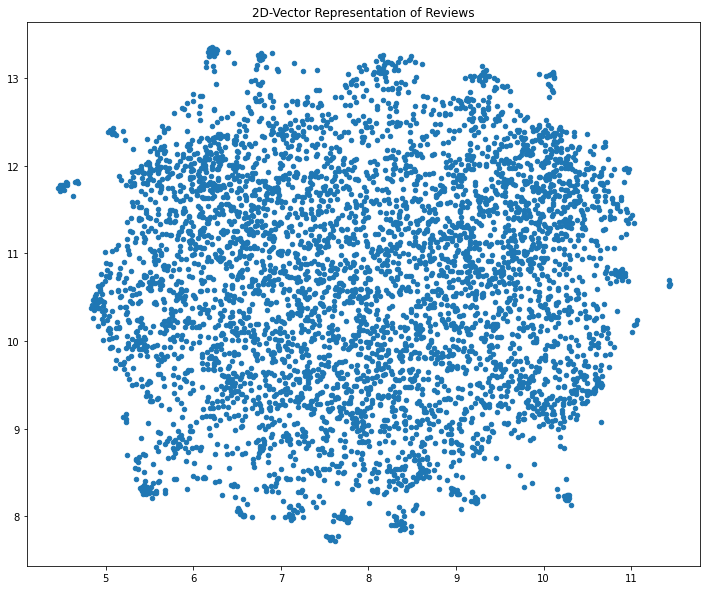

In [12]:
text_data_series = inconsitent_rating_df["reviews"]
umap_vectors = get_vec4visual(text_data_series)

umap_df = pd.DataFrame(umap_vectors, columns=("x", "y"), index=text_data_series.index).join(
    inconsitent_rating_df[["reviews", "overall_rating", "calculated_rating"]])

# uncomment below for interactive bokeh plot
"""
output_notebook()

plot = get_umap_vec_plot(umap_df)
show(plot)
"""

get_vec_plot(umap_df)

It is a bit hard to make a precise judgment for those reviews with one point difference between overall and calculated rating. And checking [SEEK](https://www.seek.com.au/) reveals that overall rating is not really calculated and is given by the user. Which makes sense why so many of the ratings are kind of inconsistent.

Anyway, This inconsistency should be dealt with. I think I will still stick to my first assumption that overall rating should represent all other `x_ratings` given. To provide a better judgment, let’s visualize those data points with more than two units of difference between overall and calculated rating.

In [13]:
inconsitent_rating_df = df[abs(df['overall_rating'] - df['calculated_rating']) > 1]
inconsitent_rating_df.shape

(310, 15)

In [14]:
text_data_series = inconsitent_rating_df["reviews"]
umap_vectors = get_vec4visual(text_data_series)

umap_df = pd.DataFrame(umap_vectors, columns=("x", "y"), index=text_data_series.index).join(
    inconsitent_rating_df[["reviews", "overall_rating", "calculated_rating"]])

output_notebook()

plot = get_umap_vec_plot(umap_df)
show(plot)

Loading BokehJS ...

In [15]:
# to have more precise look to the targeted data points
df[df.index==9536]

,job_title,recommendation,salary,date,location,career_opportunity_rating,work_life_balance_rating,work_env_rating,management_rating,benefits_rating,diversity_rating,overall_rating,company,reviews,calculated_rating
9536,Customer Service Representative,Yes,Low,2 years ago,"Melbourne VIC, Australia",4,4,4,2,4,4,3,NAB,‘Good experience but bad managerial experience.’ Lot of opportunities for development. Very hierarchical structure and no transparency and can be at the controlling end of the supervisor.,4.0


Well, investigating those reviews with two or more units of difference between overall and calculated rating, I think they are __so inconsistent__. In most cases the `x_ratings` do not comply neither with reviews’ content nore with overall ratings.
 
I think this might be a general problem with the whole dataset assuming that many reviewers are using __English__ as a second language. Also, people are probably not much willing to express themselves in words and those stars (x_ratings) may work enough for them. will check this a bit more at further stages.
 
However, for sure I will remove this part of dataset considering the fact that it’s not a big portion (about 300 data points out of almost 12.5k)

Further investigation on reviews with one point of difference between overall and calculated ratings suggests that overall rating is better representation of user opinion. So, I continue with the user `overall_rating` rather than calculated one.

In [16]:
# removing those reviews with two points difference between overall and calculated rating
df = df[~(abs(df['overall_rating'] - df['calculated_rating']) > 1)]

I will categorise review ratings in three labels which will be used for model training and development.

* ratings  1 & 2 -> 0 : __Dissatisfied__
* rating 3 -> 1 : __Disengaged__
* ratings 4 & 5 -> 2 : __Stoked__

Actually this is supported by available data if users recommend their workplace to someone else or not.


In [17]:
df.groupby(by=["overall_rating"])["recommendation"].value_counts()

overall_rating  recommendation
1               No                2035
                Yes                 10
2               No                1539
                Yes                 82
3               Yes               1195
                No                1164
4               Yes               2952
                No                  71
5               Yes               3046
                No                   7
Name: recommendation, dtype: int64

It can be observed that for those users that are either stoked or unhappy with their workplace, they strongly recommend their employer to others or vice versa.

But for those employees who rate their employers as average (I call them `disengaged`), numbers are fairly divided. Well this could be quite a challenge for the model to detect which I will get back to this during feature engineering.

In [18]:
def get_labels(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
    
df["labels"] = [get_labels(rating) for rating in df["overall_rating"]]

Another fact that should be pointed out here is that the data is not uniformly divided between those three classes which might result in a high model bias.

In [19]:
df["labels"].value_counts()

2    6076
0    3666
1    2359
Name: labels, dtype: int64

## Text Length as a Feature
--------
Let’s check text length if it could be a potential feature or not. First, let’s see how long are reviews.

Most reviews have length shorter than 500 characters.

In [20]:
df["review_len"] = df["reviews"].str.len()

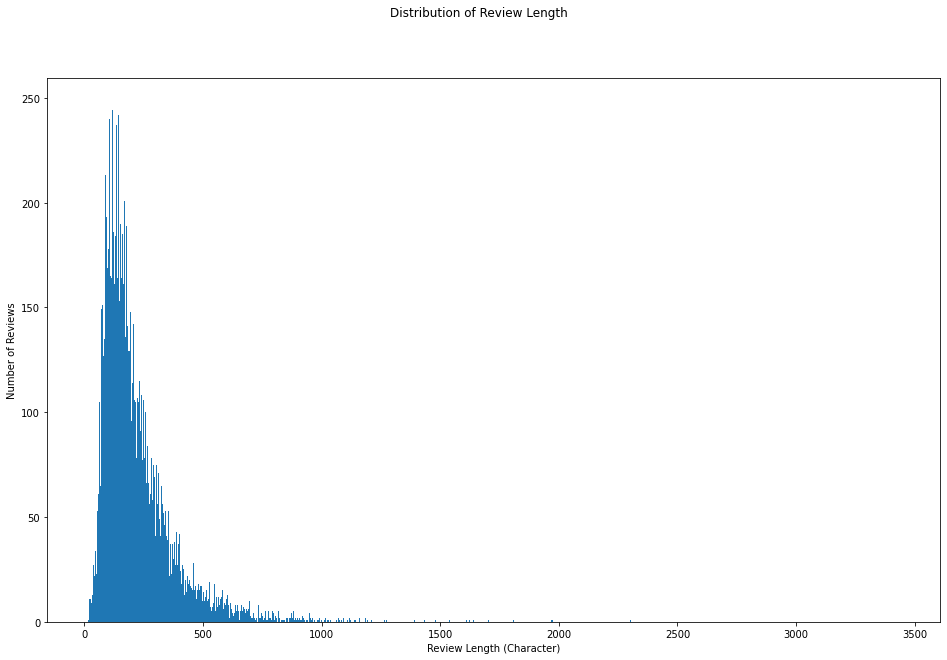

In [21]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Distribution of Review Length")
plt.xlabel("Review Length (Character)")
plt.ylabel("Number of Reviews")
plot_text_len = plt.hist(df["review_len"], bins=1000, log=False)

Let’s zoom onto the dense area and see how `length` is distributed upon each label.

Text(0, 0.5, 'Percentage of Reviews')

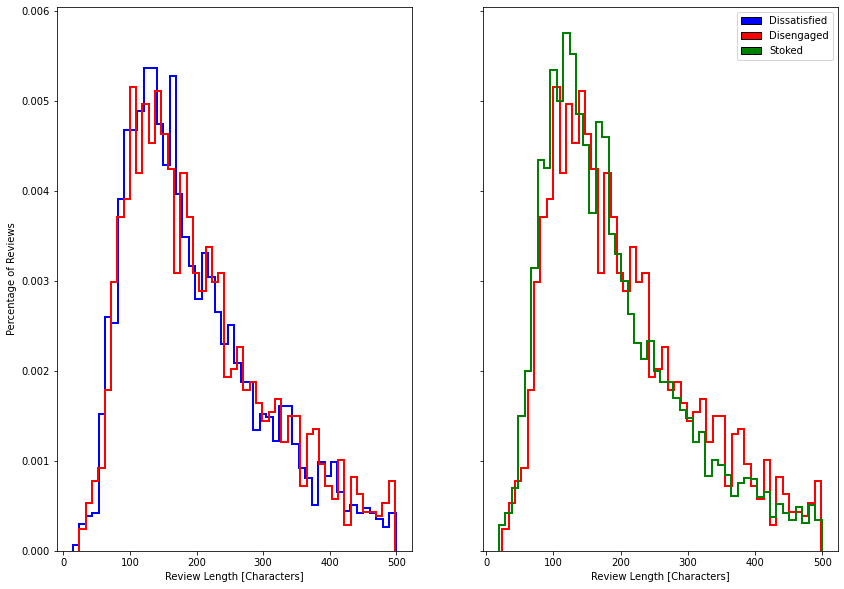

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 10))

df[(df["review_len"] < 500) & (df["labels"] == 0)]["review_len"].hist(
    bins=50,
    density=True,
    histtype='step',
    grid=False,
    color="blue",
    linewidth=2.,
    ax=ax1,
    log=False
)

for ax in [ax1, ax2]:    
    df[(df["review_len"] < 500) & (df["labels"] == 1)]["review_len"].hist(
        bins=50,
        density=True,
        histtype='step',
        grid=False,
        color="red",
        linewidth=2,
        ax=ax,
        log=False
)

df[(df["review_len"] < 500) & (df["labels"] == 2)]["review_len"].hist(
    bins=50,
    density=True,
    histtype='step',
    grid=False,
    color="green",
    linewidth=2,
    log=False,
    ax=ax2
)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ["blue", "red", "green"]
]
labels = ["Dissatisfied", "Disengaged", "Stoked"]

plt.legend(handles, labels)
ax1.set_xlabel("Review Length [Characters]")
ax2.set_xlabel("Review Length [Characters]")
ax1.set_ylabel("Percentage of Reviews")

Length distribution over different ratings seem uniform to some extent. However, the middle group of reviews (red chart) may slightly favour longer reviews.
Next, I’ll focus on `feature engineering`.
